In [1]:
import torch
from collections import Counter
# model
import models as mm
# val
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, matthews_corrcoef
# plot
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
from torch_geometric.nn import summary as summary_gnn

In [2]:
plt.style.use('seaborn-whitegrid')

## Data

In [3]:
fold_idx = 1

In [20]:
#data = torch.load(f'../../data/graph_designer/train_test_node_classification/data_{fold_idx}.pt')
data = torch.load(f'../../data/graph_designer/train_test_node_classification_days/data_{fold_idx}.pt')
data 

Data(x=[2810, 5], edge_index=[2, 4418], edge_attr=[4418, 1], y=[2810, 1], train_mask=[2529], test_mask=[281])

## Model

In [21]:
data.num_features, data.edge_attr.shape, data.edge_attr[0]

(5, torch.Size([4418, 1]), tensor([0.2540]))

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = mm.GCN(data.num_features, 
               64, 
               data.y.shape[1]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
model

GCN(
  (conv1): GCNConv(5, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [23]:
print(summary_gnn(model, data.x, data.edge_index, data.edge_attr))

+------------------+---------------------------------+----------------+----------+
| Layer            | Input Shape                     | Output Shape   |   #Param |
|------------------+---------------------------------+----------------+----------|
| GCN              | [2810, 5], [2, 4418], [4418, 1] | [2810, 1]      |      449 |
| ├─(conv1)GCNConv | [2810, 5], [2, 4418], [4418, 1] | [2810, 64]     |      384 |
| ├─(linear)Linear | [2810, 64]                      | [2810, 1]      |       65 |
+------------------+---------------------------------+----------------+----------+


In [7]:
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x.to(device), 
                data.edge_index.to(device),
                data.edge_attr.to(device))
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device)) 
    #loss = criterion(out, train_data.edge_label.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

In [8]:
def test(data):
    model.eval()
    with torch.no_grad():
        out = model(data.x.to(device), 
                    data.edge_index.to(device),
                    data.edge_attr.to(device))
        #print(f"out: {out.shape}")
        pred = out[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask].to(device).argmax(dim=1)
        return pred, true

In [9]:
loss_scores = [train(data) for _ in range(100)]

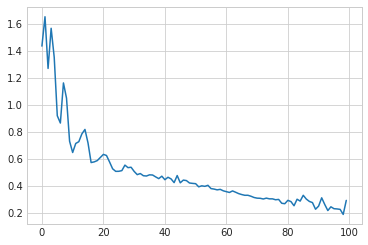

In [10]:
plt.plot(loss_scores)
plt.show()

In [11]:
y_true, y_pred = test(data)

In [12]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Compute MCC
mcc = matthews_corrcoef(y_true, y_pred)
print("MCC:", mcc)

Confusion Matrix:
[[204  25]
 [  0  53]]
MCC: 0.7780150103944392


In [13]:
# tn, fp, fn, tp
conf_matrix.ravel()

array([204,  25,   0,  53])

In [14]:
# TN FP
# FN TP

In [15]:
accuracy = accuracy_score(y_true, y_pred) 
prec     = precision_score(y_true, y_pred, average='binary')
rec      = recall_score(y_true, y_pred, average='binary')
f1       = f1_score(y_true, y_pred, average='binary')

accuracy, prec, rec, f1

(0.9113475177304965, 0.6794871794871795, 1.0, 0.8091603053435115)

In [16]:
'''
(0.7852112676056338,
 0.7873526347480926,
 0.7890330045061503,
 0.7859242853346569)
'''

'\n(0.7852112676056338,\n 0.7873526347480926,\n 0.7890330045061503,\n 0.7859242853346569)\n'

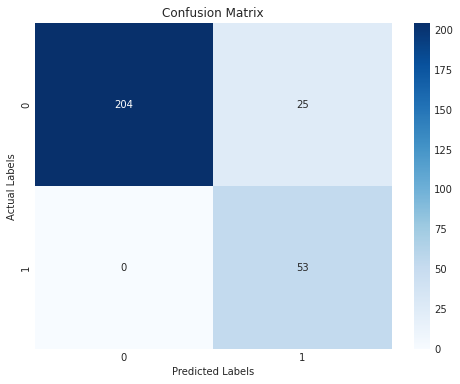

In [17]:
# Create a heatmap plot of the confusion matrix
keys = Counter(y_true.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, 
            fmt='d', cmap='Blues', 
            xticklabels=sorted(keys.keys()), 
            yticklabels=sorted(keys.keys()))

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()